In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from tqdm import tqdm

In [3]:
# set a seed
np.random.seed(1000)
# we set a dimention of a random vector
random_dim = 100

In [4]:
# load data and Normaliaing between -1, 1
def load_data_mnist():
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5)/127.5
  X_train = X_train.reshape(60000, 784)   # our training set is 6000 by 784
  return (X_train, y_train, X_test, y_test)

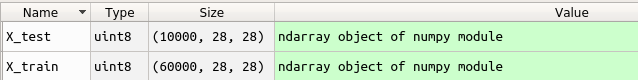

In [5]:
from keras.optimizers import legacy

# Using legacy optimizer which handles training variable updates more robustly
optimizer = legacy.Adam(learning_rate=0.0001)

In [6]:
# Creating three hidden layers + LeakyReLU as rectifier function
generator = Sequential()
generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.random_normal(stddev=0.01)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

In [7]:
# setting discriminator in teh same way
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim = 784, kernel_initializer=initializers.random_normal(stddev=0.01)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [8]:
# Since we want to train one network at a time, we set trainable to False.
# We then declare ganInput variable which will take the random dimension declared earlier.
discriminator.trainable = False
ganInput = Input(shape=(random_dim,))

In [9]:
# Combining discriminator and generator
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs = ganInput, outputs = ganOutput)
gan.compile(loss = 'binary_crossentropy', optimizer = optimizer)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the generated images from the GAN
def plot_generated_best_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10), save=True):
    # Generate random noise as input for the generator
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    # Use the generator to create images from the noise
    generated_images = generator.predict(noise)
    # Reshape the flat images returned by the generator into 2D images
    generated_images = generated_images.reshape(examples, 28, 28)

    # Create a figure with the specified size
    plt.figure(figsize=figsize)
    # Plot each image in a grid defined by 'dim'
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the plot to a file or show it, depending on the 'save' parameter
    if save:
        plt.savefig('generated_image_epoch_{:04d}.png'.format(epoch))
        plt.show()
        plt.close()  # Close the plot to free up memory
    else:
        plt.show()

In [11]:
# defining a function to do the training and generate the images
def trainM(epochs = 1, batch_size = 128):   # Split the data into bath sizes of 128
  X_train, y_train, X_test, y_test = load_data_mnist()
  batch_count = X_train.shape[0] // batch_size

  for e in range(1, epochs+1):
    print ('-'*10, 'Epoch %d' % e, '-'*10)
    for _ in range(batch_count):
      # Generating noise and the corresponding fake images from generator
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])   # Get a random set of input images
      generated_images = generator.predict(noise)

      image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

      # Concatenate real images with fake images
      X = np.concatenate([image_batch, generated_images])
      y_dis = np.zeros(2*batch_size)
      y_dis[:batch_size] = 0.9 # Apply smoothing for real images

      # Train discriminator on real and fake images
      discriminator.trainable = True    # Train the discriminator
      discriminator.train_on_batch(X, y_dis)

      # Train generator
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      y_gen = np.ones(batch_size)

      # Ensuring the discriminator is frozen during generator training
      discriminator.trainable = False
      gan.compile(loss='binary_crossentropy', optimizer=optimizer)
      gan.train_on_batch(noise, y_gen)    # Train the generator



In [ ]:
# calling the function and pass the number of epochs and batch sizes
trainM(200, 8192)

4/4 [==============================] - 0s 11ms/step


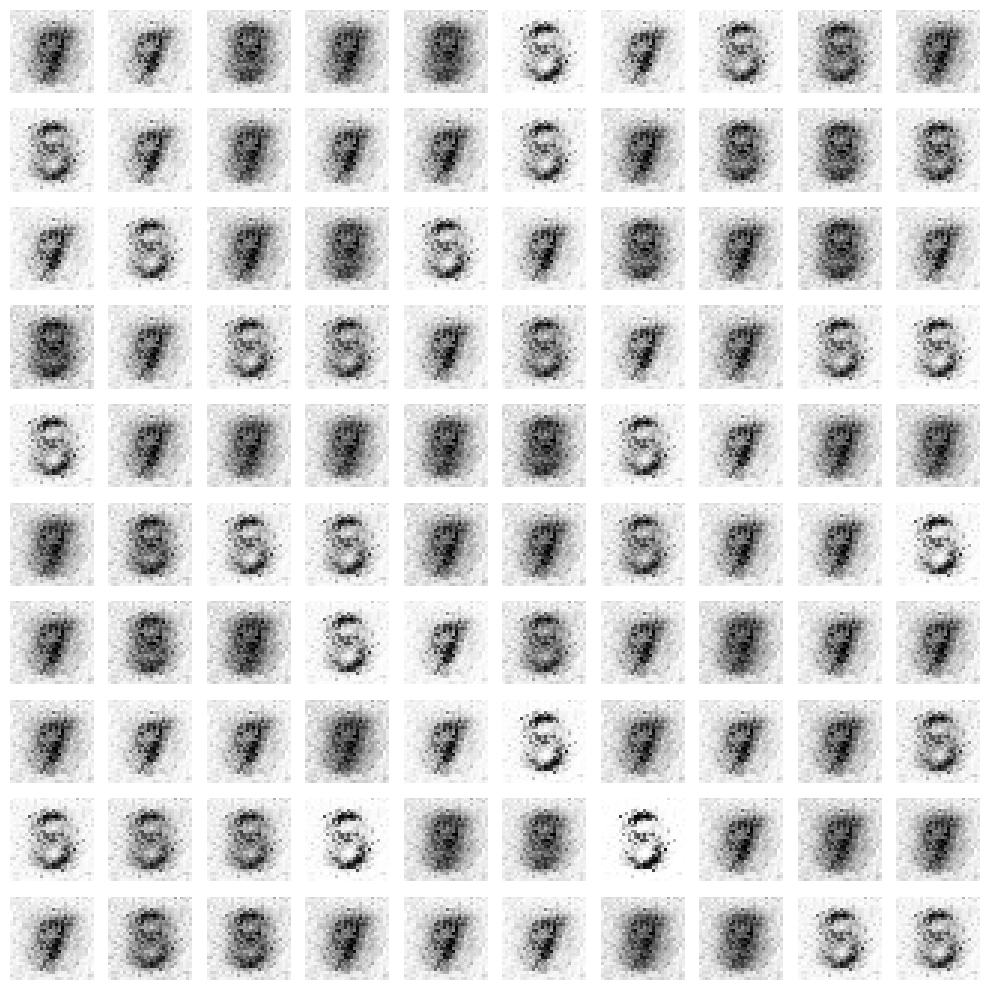

In [13]:
plot_generated_best_images(200, generator)  # Plot the generated images